In [1]:
import pandas as pd

# Load the datasets to inspect them
train_values_path = '../Mortgage_LoanApproval/train_values.csv'
train_labels_path = '../Mortgage_LoanApproval/train_labels.csv'

# Load the datasets
train_values = pd.read_csv(train_values_path)
train_labels = pd.read_csv(train_labels_path)

# Display basic info and the first few rows of each dataset
train_values_info = train_values.info()
train_labels_info = train_labels.info()

train_values_head = train_values.head()
train_labels_head = train_labels.head()

train_values_info, train_values_head, train_labels_info, train_labels_head


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500000 entries, 0 to 499999
Data columns (total 22 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   row_id                          500000 non-null  int64  
 1   loan_type                       500000 non-null  int64  
 2   property_type                   500000 non-null  int64  
 3   loan_purpose                    500000 non-null  int64  
 4   occupancy                       500000 non-null  int64  
 5   loan_amount                     500000 non-null  float64
 6   preapproval                     500000 non-null  int64  
 7   msa_md                          500000 non-null  int64  
 8   state_code                      500000 non-null  int64  
 9   county_code                     500000 non-null  int64  
 10  applicant_ethnicity             500000 non-null  int64  
 11  applicant_race                  500000 non-null  int64  
 12  applicant_sex   

(None,
    row_id  loan_type  property_type  loan_purpose  occupancy  loan_amount  \
 0       0          3              1             1          1         70.0   
 1       1          1              1             3          1        178.0   
 2       2          2              1             3          1        163.0   
 3       3          1              1             1          1        155.0   
 4       4          1              1             1          1        305.0   
 
    preapproval  msa_md  state_code  county_code  ...  applicant_sex  \
 0            3      18          37          246  ...              1   
 1            3     369          52          299  ...              1   
 2            3      16          10          306  ...              1   
 3            1     305          47          180  ...              1   
 4            3      24          37           20  ...              2   
 
    applicant_income  population  minority_population_pct  \
 0              24.0      62

In [2]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import f1_score, classification_report
from sklearn.impute import SimpleImputer
import numpy as np

# Preprocessing
# Merge features and labels based on row_id
data = pd.merge(train_values, train_labels, on='row_id')

# Drop `row_id` as it's not predictive
data = data.drop(columns=['row_id'])

# Handle missing values using median imputation
imputer = SimpleImputer(strategy='median')
data_imputed = pd.DataFrame(imputer.fit_transform(data), columns=data.columns)

# Split into features and target
X = data_imputed.drop(columns=['accepted'])
y = data_imputed['accepted']

# Stratified train-test split to maintain class balance
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Random Forest Model with class weight
rf = RandomForestClassifier(class_weight='balanced', random_state=42)

# Hyperparameter tuning
param_grid = {
    'n_estimators': [64, 128],
    'max_depth': [4,5,6],
    'min_samples_split': [8, 12, 16],
    'min_samples_leaf': [ 2, 4, 6]
}
grid_search = GridSearchCV(rf, param_grid, cv=3, scoring='f1', n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)

# Best model
best_rf = grid_search.best_estimator_

# Evaluate on test set
y_pred = best_rf.predict(X_test)
f1 = f1_score(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)


grid_search.best_params_, f1, classification_rep


Fitting 3 folds for each of 96 candidates, totalling 288 fits


({'max_depth': 4,
  'min_samples_leaf': 4,
  'min_samples_split': 12,
  'n_estimators': 64},
 0.6848827280489799,
 '              precision    recall  f1-score   support\n\n         0.0       0.69      0.55      0.61     49977\n         1.0       0.63      0.75      0.68     50023\n\n    accuracy                           0.65    100000\n   macro avg       0.66      0.65      0.65    100000\nweighted avg       0.66      0.65      0.65    100000\n')

In [4]:
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score, classification_report

# Convert data to DMatrix for XGBoost (optional, for efficiency)
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

# XGBoost Model with Hyperparameter Tuning
xgb_model = xgb.XGBClassifier(scale_pos_weight=len(y_train[y_train == 0]) / len(y_train[y_train == 1]), random_state=42)

param_grid = {
    'n_estimators': [64, 128],
    'max_depth': [8, 12, None],
    'min_child_weight': [1, 3, 5],
    'learning_rate': [0.05, 0.1, 0.5, 0.9],
    'subsample': [0.8, 1.0]
}

grid_search_xgb = GridSearchCV(
    xgb_model,
    param_grid,
    scoring='f1',
    cv=3,
    verbose=1,
    n_jobs=-1
)

grid_search_xgb.fit(X_train, y_train)

# Best model
best_xgb = grid_search_xgb.best_estimator_

# Evaluate on the test set
y_pred_xgb = best_xgb.predict(X_test)
f1_xgb = f1_score(y_test, y_pred_xgb)
classification_report_xgb = classification_report(y_test, y_pred_xgb)

print("Best Parameters:", grid_search_xgb.best_params_)
print("F1-Score:", f1_xgb)
print("Classification Report:\n", classification_report_xgb)


Fitting 3 folds for each of 144 candidates, totalling 432 fits
Best Parameters: {'learning_rate': 0.05, 'max_depth': 12, 'min_child_weight': 3, 'n_estimators': 128, 'subsample': 0.8}
F1-Score: 0.7322173787770353
Classification Report:
               precision    recall  f1-score   support

         0.0       0.75      0.64      0.69     49977
         1.0       0.68      0.79      0.73     50023

    accuracy                           0.71    100000
   macro avg       0.72      0.71      0.71    100000
weighted avg       0.72      0.71      0.71    100000



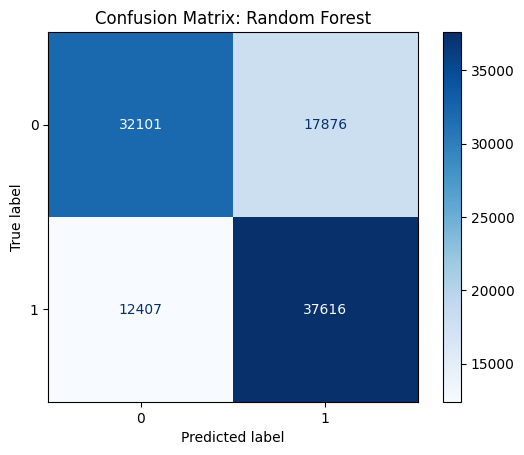

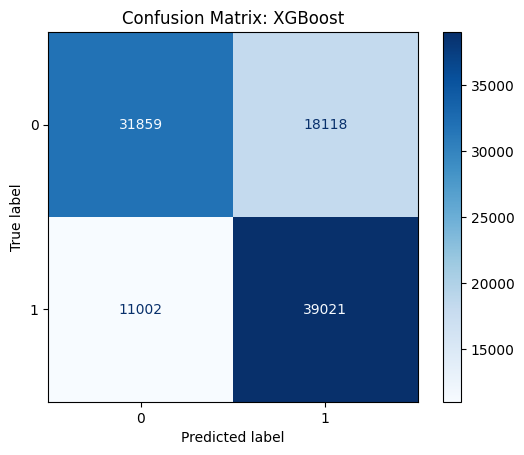

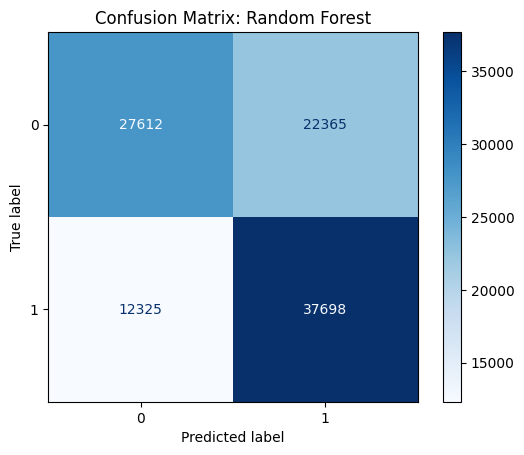

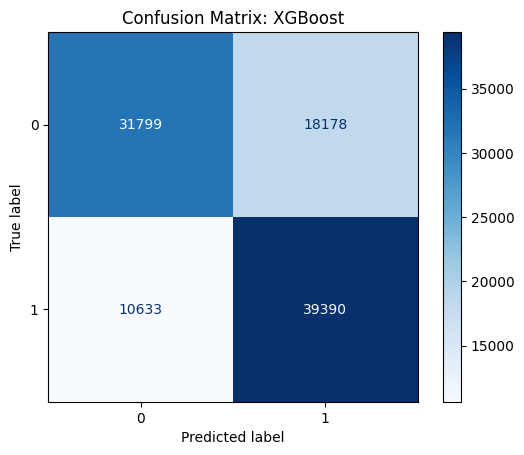

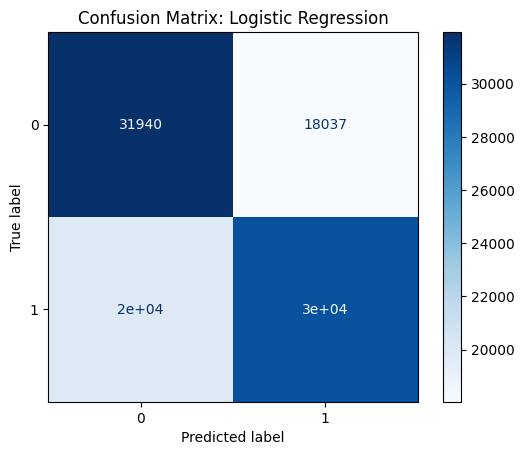

In [5]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

# Logistic Regression Model
logistic_model = Pipeline([
    ('scaler', StandardScaler()),  # Logistic Regression benefits from scaling
    ('logistic', LogisticRegression(class_weight='balanced', random_state=42, max_iter=1000))
])

# Train the model
logistic_model.fit(X_train, y_train)

# Predictions
y_pred_lr = logistic_model.predict(X_test)

# Plot Confusion Matrix
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Function to plot confusion matrix
def plot_confusion_matrix(y_true, y_pred, model_name):
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
    disp.plot(cmap='Blues')
    plt.title(f"Confusion Matrix: {model_name}")
    plt.show()

# Confusion matrices for the individual learners
plot_confusion_matrix(y_test, y_pred, model_name="Random Forest")
plot_confusion_matrix(y_test, y_pred_xgb, model_name="XGBoost")
plot_confusion_matrix(y_test, y_pred_lr, model_name="Logistic Regression")
